<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

# HOOPS AI - Minimal ETL Demo

This notebook demonstrates the core features of the HOOPS AI data engineering workflows:

## Key Components
- **Schema-Based Dataset Organization**: Define structured data schemas for consistent data merging
- **Parallel Task Decorators**: Simplify CAD processing with type-safe task definitions
- **Generic Flow Orchestration**: Automatically handle task dependencies and data flow
- **Automatic Dataset Merging**: Process multiple files into a unified dataset structure
- **Integrated Exploration Tools**: Analyze and prepare data for ML workflows

The framework automatically generates visualization assets and stream cache data to support downstream applications.

In [2]:
import hoops_ai
import os

# Note: License is also set in cad_tasks.py for worker processes
# This is only for the parent process (optional but good practice)
hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)

HOOPS AI version :  1.0.0-b2dev5 



C:\Users\LuisSalazar\AppData\Local\Temp\ipykernel_37100\2820442001.py:6: UserWarning: ⚠️ TEST LICENSE expires in 4 days (January 31, 2026)!
   Please obtain your own license from Tech Soft 3D.
   Visit: https://www.techsoft3d.com/contact/
  hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)


## Import Dependencies

The HOOPS AI framework provides several key modules:
- `flowmanager`: Core orchestration engine with task decorators
- `cadaccess`: CAD file loading and model access utilities
- `storage`: Data persistence and retrieval components
- `dataset`: Tools for exploring and preparing merged datasets

In [3]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuration Setup

Define input and output paths for CAD processing:
- Input directory containing source CAD files 
- Output directory for processed results
- Source directory with specific CAD file formats

The framework will automatically organize outputs into structured directories.

In [4]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()

datasources_dir = nb_dir.parent.joinpath("packages","cadfiles","cadsynth100","step")

if not datasources_dir.exists():
    print("Data source directory does not exist. Please check the path.")
    exit(-1)

flows_outputdir = nb_dir.joinpath("out")


## Schema Definition - The Foundation of Dataset Organization

The `SchemaBuilder` defines a structured blueprint for how CAD data should be organized:
- **Domain & Version**: Namespace and versioning for schema tracking
- **Groups**: Logical data categories (e.g., "machining", "faces", "edges")  
- **Arrays**: Typed data containers with defined dimensions
- **Metadata Routing**: Rules for routing metadata to appropriate storage

Schemas ensure consistent data organization across all processed files, enabling automatic merging and exploration.

In [5]:
# Schema is now defined in cad_tasks.py for ProcessPoolExecutor compatibility
# Import it from there to view or customize
from scripts.cad_tasks import cad_schema
print(cad_schema)

HOOPS AI version :  1.0.0-b2dev5 

{'version': '1.0', 'domain': 'Manufacturing_Analysis', 'groups': {'machining': {'primary_dimension': 'part', 'arrays': {'machining_category': {'dims': ['part'], 'dtype': 'int32', 'description': 'Machining complexity category (1-5)'}, 'material_type': {'dims': ['part'], 'dtype': 'int32', 'description': 'Material type (1-5)'}, 'estimated_machining_time': {'dims': ['part'], 'dtype': 'float32', 'description': 'Estimated machining time in hours'}}, 'description': 'Manufacturing and machining classification data'}}, 'description': 'Minimal schema for manufacturing classification', 'metadata': {'metadata': {'file_level': {}, 'categorical': {'material_type_description': {'dtype': 'str', 'required': False, 'description': 'Material classification'}}, 'routing_rules': {'file_level_patterns': [], 'categorical_patterns': ['material_type_description', 'category', 'type'], 'default_numeric': 'file_level', 'default_categorical': 'categorical', 'default_string': 'cate

C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\cad_tasks.py:47: UserWarning: ⚠️ TEST LICENSE expires in 4 days (January 31, 2026)!
   Please obtain your own license from Tech Soft 3D.
   Visit: https://www.techsoft3d.com/contact/
  license_key = hoops_ai.use_test_license()


In [6]:
# Import task functions from external module for ProcessPoolExecutor compatibility
from scripts.cad_tasks import gather_files, encode_manufacturing_data


In [7]:
from display_utils import display_task_source
display_task_source(gather_files, "gather_files")

---

### 📄 Task Source Code: `gather_files`

```python
@flowtask.extract(
    name="gather cad files",
    inputs=["cad_datasources"],
    outputs=["cad_dataset"],
    parallel_execution=True
)
def gather_files(source: str) -> List[str]:
    # Use simple glob pattern matching for ProcessPoolExecutor compatibility
    patterns = ["*.stp", "*.step", "*.iges", "*.igs"]
    source_files = []
    
    for pattern in patterns:
        search_path = os.path.join(source, pattern)
        files = glob.glob(search_path)
        source_files.extend(files)
    
    print(f"Found {len(source_files)} CAD files in {source}")
    return source_files
```


In [8]:
display_task_source(encode_manufacturing_data, "encode_manufacturing_data")

---

### 📄 Task Source Code: `encode_manufacturing_data`

```python
@flowtask.transform(
    name="Manufacturing data encoding",
    inputs=["cad_dataset"],
    outputs=["cad_files_encoded"],
    parallel_execution=True
)
def encode_manufacturing_data(cad_file: str, cad_loader: HOOPSLoader, storage: DataStorage) -> str:
    # Load CAD model using the process-local HOOPSLoader
    cad_model = cad_loader.create_from_file(cad_file)
    
    # Set the schema for structured data organization
    # Schema is defined at module level, so it's available in all worker processes
    storage.set_schema(cad_schema)
    
    # Prepare BREP for feature extraction
    hoopstools = HOOPSTools()
    hoopstools.adapt_brep(cad_model, None)
    
    # Extract geometric features using BrepEncoder
    brep_encoder = BrepEncoder(cad_model.get_brep(), storage)
    
     # Topology & Graph
    graph = brep_encoder.push_face_adjacency_graph()
    extended_adj = brep_encoder.push_extended_adjacency()
    neighbors_count = brep_encoder.push_face_neighbors_count()
    edge_paths = brep_encoder.push_face_pair_edges_path(max_allow_edge_length=16)
    
    # Geometric Indices & Attributes
    face_attrs, face_types_dict = brep_encoder.push_face_attributes()
    face_discretization = brep_encoder.push_face_discretization(pointsamples=100)
    edge_attrs, edge_types_dict = brep_encoder.push_edge_attributes()
    curve_grids = brep_encoder.push_curvegrid(ugrid=10)

    # Face-Pair Histograms
    distance_hists = brep_encoder.push_average_face_pair_distance_histograms(grid=10, num_bins=64)
    angle_hists = brep_encoder.push_average_face_pair_angle_histograms(grid=10, num_bins=64)
    
    
    # Generate manufacturing classification data
    file_basename = os.path.basename(cad_file)
    file_name = os.path.splitext(file_basename)[0]
    
    # Set seed for reproducible results based on filename
    random.seed(hash(file_basename) % 1000)
    
    # Generate classification values
    machining_category = random.randint(1, 5)
    material_type = random.randint(1, 5)
    estimated_time = random.uniform(0.5, 10.0)
    
    # Material type descriptions
    material_descriptions = ["Steel", "Aluminum", "Titanium", "Plastic", "Composite"]
    
    # Save data using the OptStorage API (data_key format: "group/array_name")
    storage.save_data("machining/machining_category", np.array([machining_category], dtype=np.int32))
    storage.save_data("machining/material_type", np.array([material_type], dtype=np.int32))
    storage.save_data("machining/estimated_machining_time", np.array([estimated_time], dtype=np.float32))
    
    # Save categorical metadata (will be routed to .attribset)
    storage.save_metadata("material_type_description", material_descriptions[material_type - 1])
    
    # Save file-level metadata (will be routed to .infoset)
    storage.save_metadata("Item", str(cad_file))
    storage.save_metadata("Flow name", "minimal_manufacturing_flow")
    
    # Compress the storage into a .data file
    storage.compress_store()

    
    return storage.get_file_path("")
```


## Flow Orchestration and Automatic Dataset Generation

The `hoops_ai.create_flow()` function orchestrates the data flow execution.
The tasks parameters can receive any function defined by the user.
This is fully editable, you can write your OWN encoding logic.

In [9]:
# Create and run the Data Flow
flow_name = "minimal_manufacturing_flow"  
cad_flow = hoops_ai.create_flow(
    name=flow_name,
    tasks=[gather_files, encode_manufacturing_data],  # Imported from cad_tasks.py
    max_workers=6,  # parallel running
    flows_outputdir=str(flows_outputdir),
    ml_task="Manufacturing Classification Demo",
    auto_dataset_export=True,  # Enable automatic dataset merging
    debug=False,  # Changed to False to enable parallel execution
    export_visualization=True
)

# Run the flow to process all files
print("Starting flow execution with ProcessPoolExecutor...")
print("✓ Schema is defined in cad_tasks.py, available to all worker processes")
flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': [str(datasources_dir)]})

# Display results
print("\n" + "="*70)
print("FLOW EXECUTION COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nDataset files created:")
print(f"  Main dataset: {output_dict.get('flow_data', 'N/A')}")
print(f"  Info dataset: {output_dict.get('flow_info', 'N/A')}")
print(f"  Attributes: {output_dict.get('flow_attributes', 'N/A')}")
print(f"  Flow file: {flow_file}")
print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
print(f"Files processed: {output_dict.get('file_count', 0)}")

Starting flow execution with ProcessPoolExecutor...
✓ Schema is defined in cad_tasks.py, available to all worker processes
|INFO| FLOW | ######### Flow 'minimal_manufacturing_flow' start #######
|WARNING| FLOW | Cleaning up existing flow directory: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow
|WARNING| FLOW | Removing all previous outputs for flow 'minimal_manufacturing_flow' to avoid build conflicts.
|INFO| FLOW | Flow directory successfully cleaned and recreated: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather cad files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Manufacturing data encoding
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: cad_files_encoded
|INFO| FLOW | Task 3:

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Manufacturing data encoding' with 101 items.


DATA TRANSFORMATION:   0%|                                                                     | 0/101 [00:00<…

|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
[DatasetMerger] Saved schema with 5 groups to metadata.json
|INFO| FLOW | Auto dataset export completed in 16.49 seconds
Sequential Task end=====================
|INFO| FLOW | Time taken: 212.76 seconds
|INFO| FLOW | ######### Flow 'minimal_manufacturing_flow' end ######

FLOW EXECUTION COMPLETED SUCCESSFULLY

Dataset files created:
  Main dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.dataset
  Info dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.infoset
  Attributes: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.attribset
  Flow file: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out/flows/minimal_manufacturing_flow/minimal_manufacturing_flow.flow

Total proc

# DATA SERVING : Use the DatasetExplorer to navigate your data

In [10]:
# Explore the generated dataset
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:62791' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_INDICES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_LENGTHS_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_TYPES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269
  EDGE_U_GRIDS_DATA: Shape: (7269, 10, 6), Dims: ('edge', 'dim_x', 'component'), Size: 436140
  FILE_ID_CODE_EDGES_DATA: Shape: (7269,), Dims: ('edge',), Size: 7269

FACEFACE_GROUP:
  A3_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  D2_DISTANCE_DATA: Shape: (87426, 64), Dims: ('faceface_index', 'face_y'), Size: 5595264
  EXTENDED_ADJACENCY_DATA: Shape: (87426,), Dims: ('faceface_index',), Size: 87426
  FACE_PAIR_EDGES_PATH_DATA: Shape: (87426, 16), Dims: ('faceface_index', 'component'), Size: 1398816
  FILE_ID_CODE_FACEFACE_DATA: Shape: (87426,), Dims: ('faceface_index

## ML-Ready Dataset Preparation

The `DatasetLoader` provides tools for preparing the merged dataset for machine learning:

### Key Capabilities:
- **Stratified Splitting**: Create train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata

In [11]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

# Split dataset by machining category with explicit group parameter
train_size, val_size, test_size = loader.split(
    key="machining_category",
    group="machining",  # Explicitly specify the group for clarity
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)

print(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

# Access training dataset
train_dataset = loader.get_dataset("train")
print(f"Training dataset ready with {len(train_dataset)} samples")

loader.close_resources()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:53389' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


DATASET STRUCTURE OVERVIEW

Group: edges
------------------------------
  edge_convexities: (7269,) (int32)
  edge_dihedral_angles: (7269,) (float32)
  edge_indices: (7269,) (int32)
  edge_lengths: (7269,) (float32)
  edge_types: (7269,) (int32)
  edge_u_grids: (7269, 10, 6) (float32)
  file_id_code_edges: (7269,) (int64)

Group: faceface
------------------------------
  a3_distance: (87426, 64) (float32)
  d2_distance: (87426, 64) (float32)
  extended_adjacency: (87426,) (float32)
  face_pair_edges_path: (87426, 16) (int32)
  file_id_code_faceface: (87426,) (int64)

Group: faces
------------------------------
  face_areas: (2796,) (float32)
  face_discretization: (2796, 100, 7) (float32)
  face_indices: (2796,) (int32)
  face_loops: (2796,) (int32)
  face_neighborscount: (2796,) (int32)
  face_types: (2796,) (int32)
  file_id_code_faces: (2796,) (int64)

Group: graph
------------------------------
  edges_destination: (7269,) (int32)
  edges_source: (7269,) (int32)
  file_id_code_gra

## Summary: The HOOPS AI - Data Flow Advantage

This minimal example demonstrates how HOOPS AI simplifies CAD data processing for ML:

1. **Schema-First Approach**: Define your data structure before processing
2. **Decorator-Based Tasks**: Easily inject custom processing logic
3. **Automatic Orchestration**: Let the framework handle execution complexity
4. **Unified Dataset**: Get consistently merged data ready for ML
5. **Built-in Exploration**: Analyze and prepare datasets with powerful tools

The framework automatically generates visualization assets and stream caches, making it easy to integrate with downstream visualization tools.

In [12]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Material distribution created in 1.53 seconds



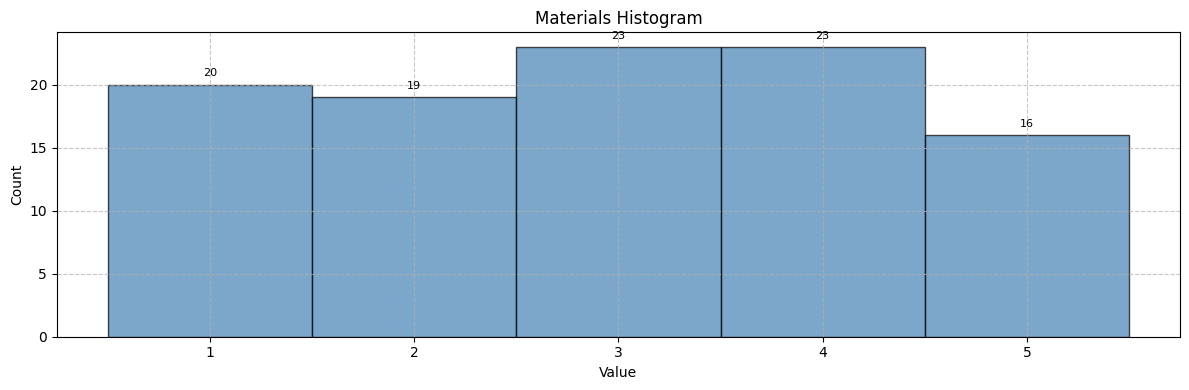

In [13]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="machining_category", bins=None, group="machining")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Materials")

## Dataset Visualization with DatasetViewer

The **DatasetViewer** is a powerful visualization tool that bridges dataset queries and visual analysis. It enables you to quickly visualize query results in two ways:

1. **Image Grids**: Generate collages of PNG previews for rapid visual scanning
2. **Interactive 3D Views**: Open inline 3D viewers for detailed model inspection

In [14]:
# Import the DatasetViewer from the insights module
from hoops_ai.insights import DatasetViewer

# Create a DatasetViewer using the convenience method from_explorer
# This method queries the explorer and builds the file ID to visualization path mappings
dataset_viewer = DatasetViewer.from_explorer(explorer)

2026-01-26 09:55:29 | INFO | hoops_ai.insights.dataset_viewer | Initialized process pool with 4 workers
2026-01-26 09:55:29 | INFO | hoops_ai.insights.dataset_viewer | DatasetViewer initialized with reference directory: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow
2026-01-26 09:55:29 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 101 files


In [15]:
print(hoops_ai)

<module 'hoops_ai' from 'C:\\Users\\LuisSalazar\\MAIN\\repos\\ML-Initiative\\src\\hoops_ai\\__init__.py'>


In [16]:
start_time = time.time()

# condition
material_is_frequent = lambda ds: ds['material_type'] == 2

filelist = explorer.get_file_list(group="machining", where=material_is_frequent)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(filelist)

Filtering completed in 0.09 seconds
[ 0  5 12 19 26 27 38 40 41 42 43 47 50 55 57 75 79 95]


### Example 1: Visualize Query Results as Image Grid

Now let's use the query results we obtained earlier and visualize them as a grid of images. This is perfect for quickly scanning through many files to understand patterns or identify specific cases.

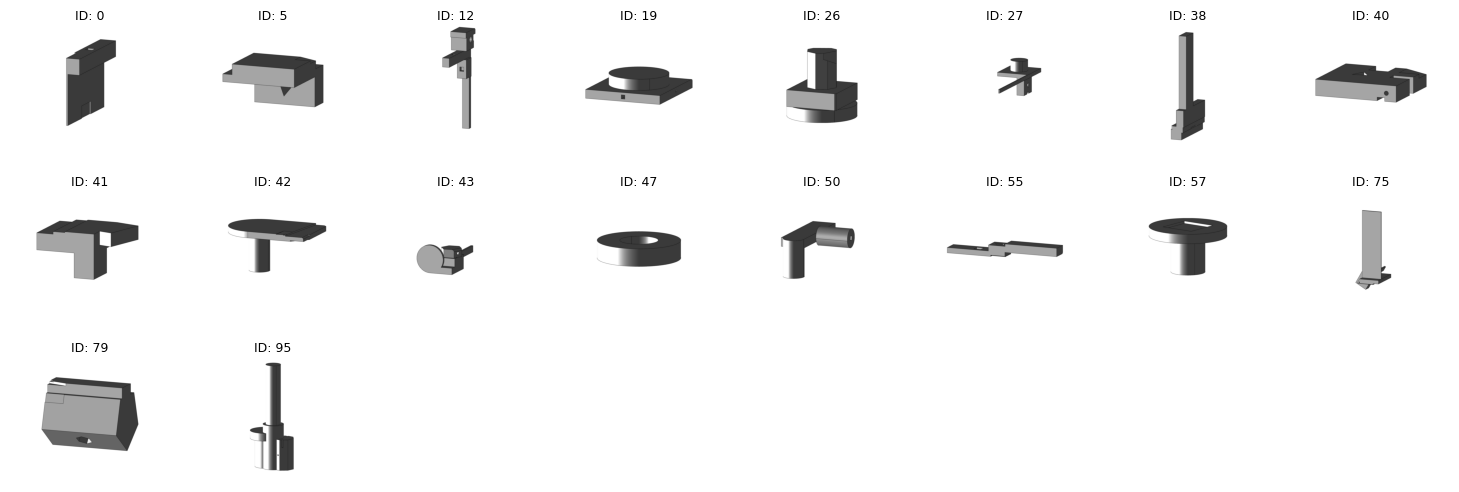

In [17]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    filelist, 
    k=len(filelist),                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    label_format='id',         # Show file IDs as labels
    figsize=(15, 5)           # Larger figure size
)

plt.show()

In [18]:
# Visualize the filtered files as interactive 3D viewers
viewers = dataset_viewer.show_preview_as_3d(
    filelist, 
    k=min(len(filelist), 5),  # Limit to 5 viewers (can be resource intensive)
    display_mode='inline',     # 'inline' or 'sidecar'
    width=400,                 # Width of each inline viewer
    height=400                 # Height of each inline viewer
)



2026-01-26 09:55:33 | INFO | hoops_ai.insights.dataset_viewer | Loading stream cache file: 04a34115a1e95ff1233935790a2fe505.scs
2026-01-26 09:55:33 | INFO | hoops_ai.insights.dataset_viewer | Using static folder: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\stream_cache
2026-01-26 09:55:33 | INFO | hoops_ai.insights.dataset_viewer | Created viewer on port 8001 for file ID 0
2026-01-26 09:55:34 | INFO | hoops_ai.insights.dataset_viewer | Loading SCS file: 04a34115a1e95ff1233935790a2fe505.scs
2026-01-26 09:55:34 | INFO | hoops_viewer.controller | Mounted external static folder 'C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\stream_cache' at /model
2026-01-26 09:55:34 | INFO | hoops_viewer.controller | Starting server at http://127.0.0.1:8001
2026-01-26 09:55:35 | INFO | hoops_viewer.controller | Setting model path to http://127.0.0.1:8001/model/04a34115a1e95ff1233935790a2fe505.scs
2026

HBox()

2026-01-26 09:55:43 | INFO | hoops_ai.insights.dataset_viewer | Displayed 5 viewers in grid layout
2026-01-26 09:55:43 | INFO | hoops_ai.insights.dataset_viewer | Successfully created 5 3D viewers


In [19]:
# When done, clean up the viewers:
for v in viewers:
    v.terminate()

2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Dispose endpoint triggered successfully.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Server shutdown triggered.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Dispose endpoint triggered successfully.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Server shutdown triggered.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Dispose endpoint triggered successfully.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Server shutdown triggered.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Dispose endpoint triggered successfully.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Server shutdown triggered.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Dispose endpoint triggered successfully.
2026-01-26 09:55:43 | INFO | hoops_viewer.controller | Server shutdown triggered.
